# Homework 1 (WIP)

Use a Chebyshev method to solve the second order ordinary differential equation

$$ u''(t) + a u'(t) + b u(t) = f(t) $$

from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.

* Do a grid convergence study to test the accuracy of your method.
* Setting $f(x)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.


In [212]:
%precision 3
%matplotlib notebook

import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

# functions: cosspace, vander_chebyshev, chebeval
# class: exact_tanh
%run chebyshev_support.py

## Solving the ODE: Discussion

### Convert to First Order System

We will handle the second order differential equation as a system of first order ODEs, using these new variables:

$$\begin{align*}
u_0(t) &= u(t)\\
u_1(t) &= u'(t)
\end{align*}$$

Substituting these into the ODE, we get the following equation:

$$ u_1'(t) + au_1(t) + bu_0(t) = f(t)$$

So, the system of differential equation we'll solve is

$$\begin{align*}
u_0' - u_1 &= 0\\
u_1' + au_1 + bu_0 &= f
\end{align*}$$

The initial conditions are

$$u_0(0) = 1\\ u_1(0) = 0$$

We'll handle the system using matrices, using this setup:

$$\begin{bmatrix}
 \frac{\mathrm{d} }{\mathrm{d} t} & -1\\
  b & \frac{\mathrm{d} }{\mathrm{d} t} + a
\end{bmatrix}
\begin{bmatrix}
 u_0\\
 u_1
\end{bmatrix} = 
\begin{bmatrix}
 0\\
 f
\end{bmatrix}$$




### Discretize

We're looking to create a linear system that looks like the one below to discretize the system above.

$$L\mathbf{u} = \mathbf{g}$$

Suppose we're looking at $n$ points. $\mathbf{u}$ and $\mathbf{g}$ , each vectors of length $2n$ will represent the values of the $u_i$ functions and right-hand side functions at those points, and can be viewed as being composed of two subvectors:

$$\mathbf{u} = \begin{bmatrix}
 \mathbf{u_0}\\
 \mathbf{u_1}
\end{bmatrix}, 
\mathbf{g} = \begin{bmatrix}
 0\\
 \mathbf{f}
\end{bmatrix}, $$

The upper halves of the will correspond to the discretization of the first ODE of the system, and the lower half will correspond to the second.

The upper and lower halves of the $M$ matrix (size $2n \times 2n$) come from discrete approximations of the left-hand side matrix from the last section. Define $T$ as an $n\times n$ Vandermonde matrix where terms evaluate the $n$-term Chebychev polynomial at our $n$ points; $T'$ dos the same with the derivatives of the polynomial. Note that to create Chebyshev polynomials for our time interval $t \in [0,1]$, we must adjust to $x \in [-1, 1]$ ($x = 2t - 1$).

The first step to building $L$ is

$$L_{WIP} = \begin{bmatrix}
  T' & -T\\
  bT & T' + aT
\end{bmatrix}$$

Applying the initial conditions to the submatrices of $L_{WIP}$,$\mathbf{u}$, and $\mathbf{g}$ will follow the same general approach as applying boundary conditions to a problem being solved with Chebyshev polynomials, as used in lecture and [this notebook](../notes/chebyshev-bvp.ipynb). It affects the first rows of the upper left and lower right submatrices of $L_{WIP}$, and the first elements of the subvectors of $\mathbf{g}$.

We additionally post-multiply each of the four square submatrices of the modified $L_{WIP}$ by $T^{-1}$, to interpolate from the point vectors we apply the resulting $L$ matrix to.

## Solving the ODE: Code

Below is a Python implementation of the solution approach described above.

In [213]:
def hw_cheb(n, rhsfunc, u_iv, du_iv, a = 1, b = 1):
    """
    Solve the homework 1 initial value problem on [0, 1] using n elements with 
    rhsfunc(x) forcing.

    The equation being solved is u''(t) + au(t) + bu(t) = f(t)
    It is converted to the following first-order system using u_0 = u, u_1 = u':
      u_0' - u_1 = 0
      u_1' + au_1 + bu_0 = f
    
    u_iv specifies the initial condition u(0) = u_iv
    du_iv specifies the initial condition u'(0) = du_iv
    """
    # n+1 points is n "elements"
    t = cosspace(0, 1, n+1)
    
    # Get a matrix to pre-multiply with a coefficient vector to produce
    #  [0]: Chebyshev expansion of a function evaluated at the points in x
    #  [1]: 1st derivative of the Chebyshev expansion evaluated at the points x
    #  [2]: 2nd derivative of the Chebyshev expansion evaluated at the points x
    # Since the Chebyshev polynomials are valid on [-1, 1], we need to adjust
    # our interval from [0, 1]. This is x = 2t - 1. 
    cheb_polys = chebeval(2 * t - 1)
    
    # Carry the variable substitution through the derivative. (dx/dt = 2)
    cheb_polys[1] *= 2 
    cheb_polys[2] *= 4
    
    # Initial prep for the left hand side matrix
    # These arise from handling the system of equations as matrices:
    #  [ d/dt      -1     ] * [ u_0 ] = [ 0 ]
    #  [  b    (d/dt + a) ]   [ u_1 ]   [ f ] 
    L = numpy.zeros((2 * (n+1), 2 * (n+1)))
    L[:n+1,:n+1] = cheb_polys[1]                      # upper right
    L[:n+1,n+1:] = - cheb_polys[0]                    # upper left
    L[n+1:,:n+1] = b * cheb_polys[0]                  # lower right
    L[n+1:,n+1:] = cheb_polys[1] + a * cheb_polys[0]  # lower left

    # Initial setup for the right hand side vector (see above)
    rhs = numpy.zeros((2 * (n+1), 1))
    rhs[n+1:] = numpy.array([rhsfunc(t)]).T
    
    # Now we'll apply the initial conditions. On the left hand side, this
    # affects the first row of the upper left submatrix (dealing with u_0/u at 
    # t=0) and of the lower left submatrix (dealing with u_1/u' at t=0). On the
    # right hand side, this affects the first elements of the upper and lower 
    # halves of the vector.
    L[0,:n+1] = cheb_polys[0][0]
    rhs[0] = u_iv
    L[n+1,n+1:] = cheb_polys[1][0]
    rhs[n+1] = du_iv
    
    # Clear out the other halves of the rows we changed to set initial
    # conditions, so those rows only contribute those initial conditions.
    L[0,n+1:] = 0
    L[n+1,:n+1] = 0
    
    # The final left hand side operator includes applying T^-1; when it's 
    # applied to a vector of function points, we get back the coefficients of 
    # the interpolating polynomial for that function (these are used with L to 
    # evaluate that function's derivatives and the initial conditions).
    T_inv = numpy.linalg.inv(cheb_polys[0]);
    L[:n+1,:n+1] = L[:n+1,:n+1] @ T_inv    # upper right
    L[:n+1,n+1:] = L[:n+1,n+1:] @ T_inv    # upper left
    L[n+1:,:n+1] = L[n+1:,:n+1] @ T_inv    # lower right
    L[n+1:,n+1:] = L[n+1:,n+1:] @ T_inv    # lower left
    
    return t, L, rhs


To test it, we'll use the familiar solution $u(t) = \tanh(k (t - t_0))$.

<IPython.core.display.Javascript object>


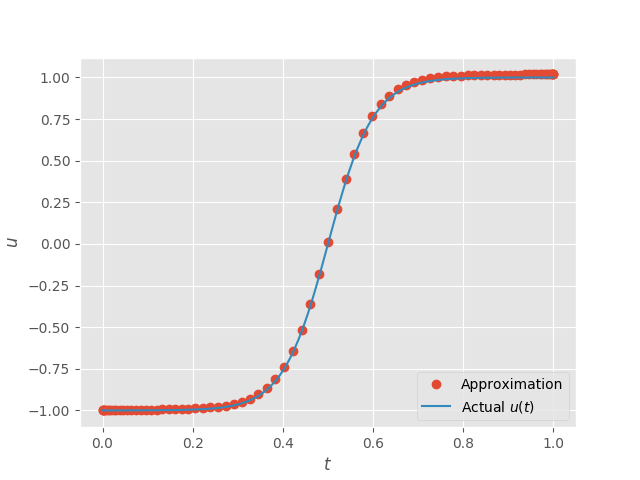

In [248]:
n = 80
a = 1
b = 1
ex = exact_tanh(10, 0.5)

rhs_func = lambda t: ex.ddu(t) + a * ex.du(t) + b * ex.u(t)
t, M, rhs = hw_cheb(n, rhs_func, u_iv = ex.u(0), du_iv = ex.du(0), a = a, b = b)

# Calculate and plot the approximate solution
full_solution = numpy.linalg.solve(M, rhs)
u_points = full_solution[:n+1]
pyplot.plot(t, u_points, 'o', label='Approximation')

# Plot the exact solution
tt = numpy.linspace(0, 1, 100)
pyplot.plot(tt, ex.u(tt), label='Actual $u(t)$');
pyplot.xlabel('$t$')
pyplot.ylabel('$u$')
pyplot.legend(loc='lower right');

## Convergence Study

## Experiments with $a$ and $b$